# OpenCV Connected Component Labeling and Analysis


연결된 컴포넌트 분석방법을 통해 자동차 번호판으로부터 자동차 번호판을 자동 추출하는 예제를 다룬다.
이를 위해서는 다음과 같은 절차로 진행될 것이다.

* 연결컴포넌트 분석을 통해 컴포넌트 및 통계값 추출 및 시각화
* 컴포넌트의 너비, 높이, 넓이등을 검사해 자동차번호가 아닌 다른 문자를 필터링
* [Otsu's Binarization](https://hoony-gunputer.tistory.com/entry/opencv-python-이미지-Thresholding)
  - 이미지의 흑백화처리(이진 이미지)의 한 방법

### 이미지 다운로드

In [22]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-connected-components/opencv-connected-components.zip
!unzip -qq opencv-connected-components.zip
%cd opencv-connected-components

--2021-04-23 09:09:53--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-connected-components/opencv-connected-components.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.232.225
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.232.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60417 (59K) [binary/octet-stream]
Saving to: ‘opencv-connected-components.zip’

opencv-connected-co 100%[===================>]  59.00K   364KB/s    in 0.2s    

2021-04-23 09:09:54 (364 KB/s) - ‘opencv-connected-components.zip’ saved [60417/60417]

/content/opencv-connected-components/opencv-connected-components


## 코드 수행

### 패키지 임포트 

In [13]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

### 코랩 및 쥬피터 노트북에서 이미지 표출함수 

In [14]:
def plt_imshow(title, image):
  '''
  이미지의 채널을 BRG에서 RGB로 변환하고 이미지 화면에 리턴
  '''
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.title(title)
  plt.imshow(image)
  plt.grid(False)
  plt.show()

### Implementing basic connected components with OpenCV

In [15]:
# 파이썬 스크립트를 터미널에서 수행
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# ap.add_argument("-c", "--connectivity", type=int, default=4,
# 	help="connectivity for connected component analysis")
# args = vars(ap.parse_args())

# 쥬피터 혹은 코랩에서 수행시 
args = {
    "image": "license_plate.png",
    "connectivity": 4
}

#### 기본 임계처리 
- 이진화처리는 간단하지만, 쉽지 않은 문제를 가지고있다. 단순히 영상 혹은 이미지를 흑백처리하는 것이지만, 어떤 기준(임계값)를 가지고 결정할 것인가의 문제가 대두됩니다.
- 이때 사용되는것이 `cv2.threshold()`이다.

In [ ]:
help(cv2.threshold)

Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a

* [이미지 thresholding](https://hoony-gunputer.tistory.com/entry/opencv-python-%EC%9D%B4%EB%AF%B8%EC%A7%80-Thresholding)
* [이미지 임계처리](https://opencv-python.readthedocs.io/en/latest/doc/09.imageThresholding/imageThresholding.html)

In [29]:
# 1.load the input image from disk, convert it to grayscale, and
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2.grayscale이미지를 임계값보다 크면 255로 바꿔주고, 낮으면 0
# cv2.threshold(src, thresh, maxval, type) → retval, dst
# src – input image로 single-channel 이미지.(grayscale 이미지)
# thresh – 임계값
# maxval – 임계값을 넘었을 때 적용할 value
# type – thresholding type
retVal, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

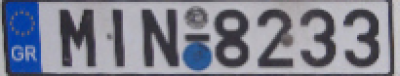

In [18]:
from IPython.display import Image
Image("/content/opencv-connected-components/license_plate.png")

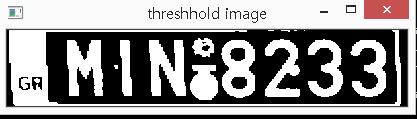

In [9]:
Image("/content/opencv-connected-components/license_plate1.PNG")

위에서 보듯히 이미지를 grayscale로 변환하고 임계치를 적용한 이미지를 보면 배경색이 검정에 흰색으로 바뀌었지만 번호판 문자뿐만 아니라, 바탕색에도 부분적으로 잡티가 존재함을 알수있다.

바로 아래 이어질 부분에서 임계값을 가지고 적용하는 방법을 알아본다.

In [10]:
help(cv2.connectedComponentsWithStats)

Help on built-in function connectedComponentsWithStats:

connectedComponentsWithStats(...)
    connectedComponentsWithStats(image[, labels[, stats[, centroids[, connectivity[, ltype]]]]]) -> retval, labels, stats, centroids
    .   @overload
    .   @param image the 8-bit single-channel image to be labeled
    .   @param labels destination labeled image
    .   @param stats statistics output for each label, including the background label, see below for
    .   available statistics. Statistics are accessed via stats(label, COLUMN) where COLUMN is one of
    .   #ConnectedComponentsTypes. The data type is CV_32S.
    .   @param centroids centroid output for each label, including the background label. Centroids are
    .   accessed via centroids(label, 0) for x and centroids(label, 1) for y. The data type CV_64F.
    .   @param connectivity 8 or 4 for 8-way or 4-way connectivity respectively
    .   @param ltype output image label type. Currently CV_32S and CV_16U are supported.



In [30]:
# apply connected component analysis to the thresholded image
output = cv2.connectedComponentsWithStats(thresh, args["connectivity"], cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

* numLabels  - 감지된 연결컴포넌트(숫자, 문자, 얼룩, 배경, 사각형 등등)
* Labels - 공간의 차원과 동일(Spatial Dimensions)하면 컴포넌트가 가지고있는 픽셀의 배열이라고 이해하자.
* stats - 각 컴포넌트의 통계정보(x좌표, y좌표, 높이, 너비, 넓이)
* centroids - 각 컴포넌트의 중심점

[INFO] examining componet 1/17 )background


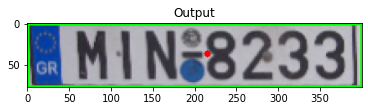

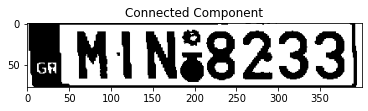

[INFO] examining component 2/17


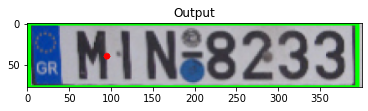

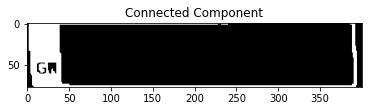

[INFO] examining component 3/17


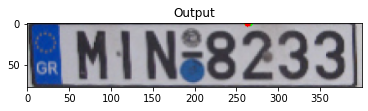

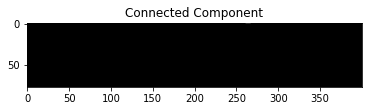

[INFO] examining component 4/17


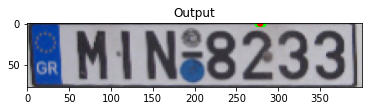

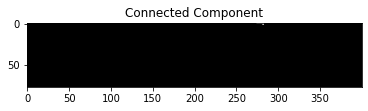

[INFO] examining component 5/17


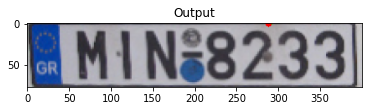

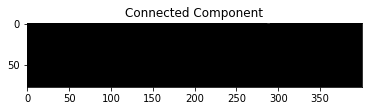

[INFO] examining component 6/17


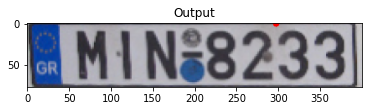

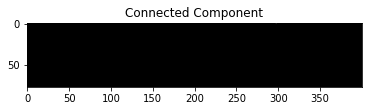

[INFO] examining component 7/17


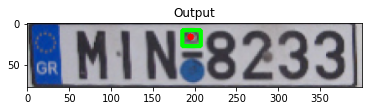

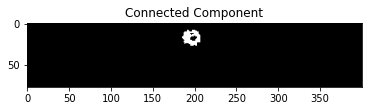

[INFO] examining component 8/17


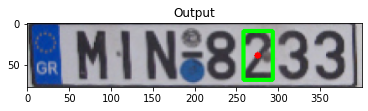

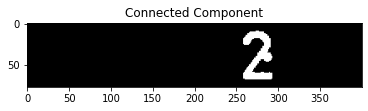

[INFO] examining component 9/17


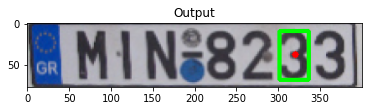

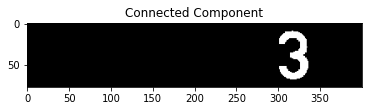

[INFO] examining component 10/17


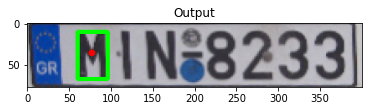

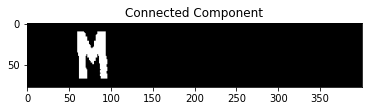

[INFO] examining component 11/17


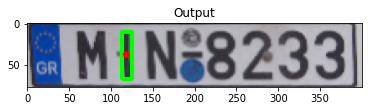

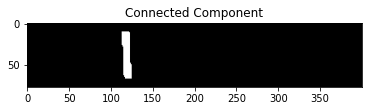

[INFO] examining component 12/17


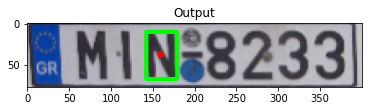

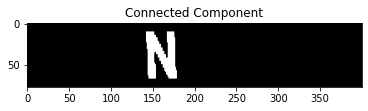

[INFO] examining component 13/17


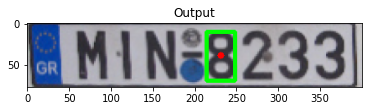

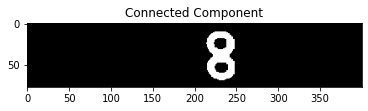

[INFO] examining component 14/17


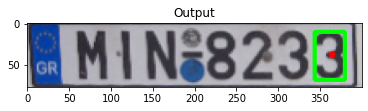

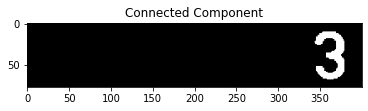

[INFO] examining component 15/17


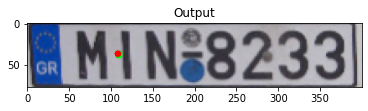

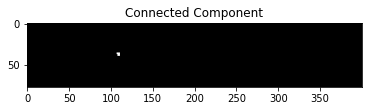

[INFO] examining component 16/17


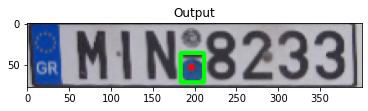

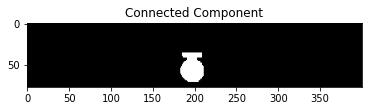

[INFO] examining component 17/17


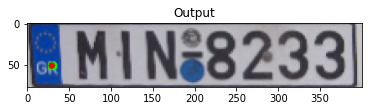

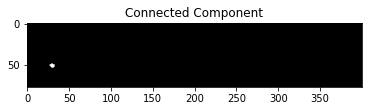

In [39]:
# 감지된 컴포넌트 갯수만큼 루프
for i in range(0, numLabels):
  # if this is the first component then we examining the
	# *background* (typically we would just ignore this
	# component in our loop)

  if i == 0:
    text = "examining componet {}/{} )background".format(i + 1, numLabels)
  else: # otherwise, we are examining an actual connected component
    text = "examining component {}/{}".format( i + 1, numLabels)

  # print a status message update for the current connected
	# component
  print("[INFO] {}".format(text))
  
  # extract the connected component statistics and centroid for
	# the current label

  # bounding box 사각형을 만들기 위해 각 좌표
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]	
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  area = stats[i, cv2.CC_STAT_AREA]

  # bounding box안에 원의 중심
  (cX, cY) = centroids[i]
  
  # clone our original image (so we can draw on it) and then draw
	# a bounding box surrounding the connected component along with
	# a circle corresponding to the centroid
  output = image.copy()
  cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)  # 컴포넌트를 명확하게 보여주기 위해 테두리 쳐서 보여주기 위한 사각형박스
  cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)     # 컴포넌트의 중심점

	# construct a mask for the current connected component by
	# finding a pixels in the labels array that have the current
	# connected component ID
  componentMask = (labels == i).astype("uint8") * 255

	# show our output image and connected component mask
  plt_imshow("Output", output)
  plt_imshow("Connected Component", componentMask)


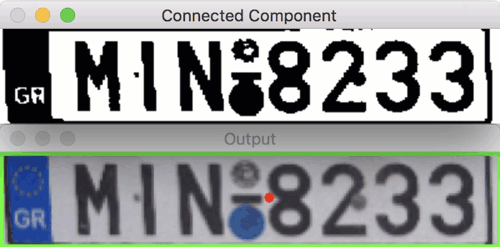

### OpenCV를 이용해 자동차 번호만 필터링 

In [47]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# ap.add_argument("-c", "--connectivity", type=int, default=4,
# 	help="connectivity for connected component analysis")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "license_plate.png",
    "connectivity": 4
}

In [49]:
# load the input image from disk, convert it to grayscale, and
# threshold it
# threshold type - THRESH_BINARY_INV, THRESH_OTSU
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
retVal, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# apply connected component analysis to the thresholded image
# cv2.CV_32S
output = cv2.connectedComponentsWithStats(thresh, args["connectivity"], cv2.CV_32S)
# 컴포넌트 갯수, 각 컴포넌트 ndarray배열 값, 각 컴포넌트의 통계치(x위치, y위치, 너비, 높이, 넓이),
(numLabels, labels, stats, centroids) = output

# initialize an output mask to store all characters parsed from
# the license plate
# 자동차 번호판으로 부터 파싱된 모든 문자를 저장할 ndarray
mask = np.zeros(gray.shape, dtype='uint8')

In [ ]:
# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, numLabels):
	# extract the connected component statistics for the current
	# label
  # 사각형을 만들기 위한 통계치에서 좌표정보
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  w = stats[i, cv2.CC_STAT_WIDTH]
  area = stats[i, cv2.CC_STAT_AREA]	
  
	# ensure the width, height, and area are all neither too small
	# nor too big
	keepWidth = w > 5 and w < 50
	keepHeight = h > 45 and h < 65
	keepArea = area > 500 and area < 1500

	# ensure the connected component we are examining passes all
	# three tests
	if all((keepWidth, keepHeight, keepArea)):
		# construct a mask for the current connected component and
		# then take the bitwise OR with the mask
		print("[INFO] keeping connected component {}".format(i))
		componentMask = (labels == i).astype("uint8") * 255
		mask = cv2.bitwise_or(mask, componentMask)

# show the original input image and the mask for the license plate
# characters
plt_imshow("Image", image)
plt_imshow("Characters", mask)

### 정리
* 첫번째 컴포넌트 - 검정배경 이미지-로 시작해서 마지막 16번째 이미지까지 녹색의 바운딩박스와 함께 중심이 되는 좌표를 빨간색으로 지정해 보여주면서 컴포넌트의 갯수만큼 이동하면서 보여줌을 알 수 있다.

* ALPR / ANPR (Automatic License / Number Plate Recognition) 시스템을 구축하는 경우 이러한 문자를 인식을 위해 OCR (Optical Character Recognition) 알고리즘에 전달합니다. 그러나 이 모든 것은 우리가 문자 및 숫자를 이진화하고 추출 할 수 있다는 데 달려 있습니다. 이러한 역할을 연결된 구성 요소 분석을 통해 우리가 할 수 있었습니다.